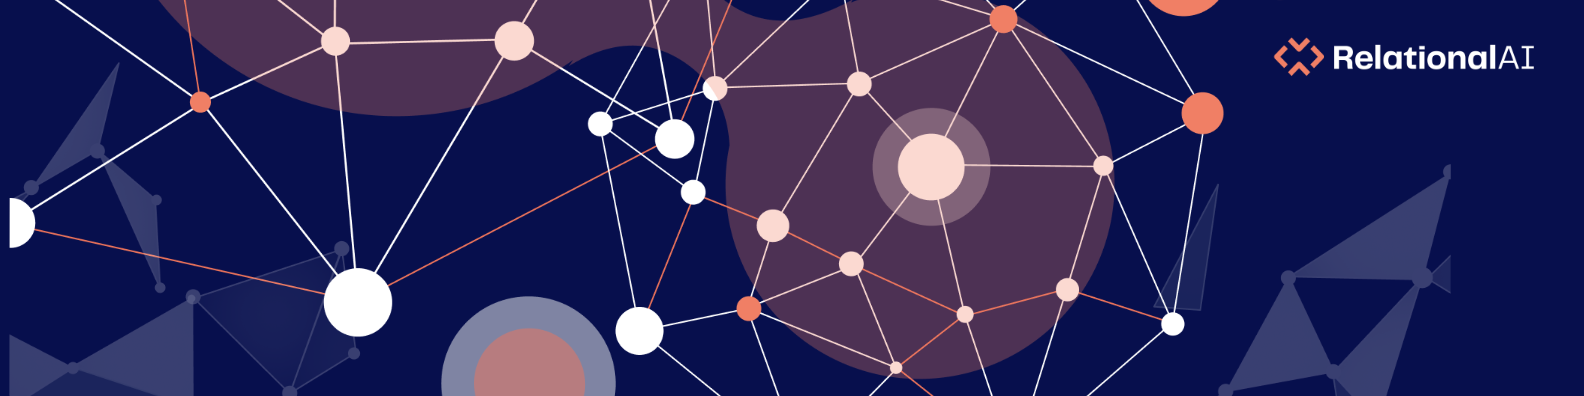

# Question Answering On Knowledge Graphs Using RelationalAI & Snowflake Cortex AI

## **Overview**

We develop an end-to-end system for answering natural language (NL) questions using a Knowledge Graph (KG), leveraging RelationalAI and Snowflake Cortex AI. Our approach ensures factual accuracy by grounding response in the KG, eliminating the risk of hallucinations typical of LLMs. 

Our work is an adaptation of [QirK: Question Answering via Intermediate Representation on Knowledge Graphs](https://arxiv.org/abs/2408.07494)

- We aim to answer the following questions from our KG.

In [1]:
list_of_questions = [
    "Name the actors of The Silent One.",
    "Who is the director of The Quiet Place?",
    "List movies directed by John Kransinski.",
    "Which movie's director is married to a cast member?",
    "Which movie's director was born in the same city as one of the cast members?",
    'Name a movie whose producer is the sibling of one of the cast members.',
    'In which movie is one of the cast members the child of the director?', 
    'Name films directed by either Christopher Nolan or Steven Spielberg.',
    'Name movies either directed or produced by Steven Spielberg.',
    'List the movies that had both Robert De Niro and Al Pacino casted in them?',
    'Who\'s the editor of a film directed by Christopher Nolan that has Christian Bale as a cast member?',
    'Name a movie directed by Quentin Tarantino or Martin Scorsese that has De Niro as a cast member.',
    "Name a movie directed by Quentin Tarantino or Martin Scorsese that has both Samuel L. Jackson and Robert De Niro as cast member"
]

> **_NOTE:_** Before running the notebook, you need to have :

1. relationalai python package installed. Follow the instructions [here](https://relational.ai/docs/getting_started#install-the-relationalai-python-package) to install that. 

2. [Snowlake Python API](https://pypi.org/project/snowflake/) package 
    ```sh
        pip install snowflake
    ```

### Step 1. **Importing Necessary Packages**

We start by importing various packages and modules that we'll need for our project.

In [2]:
# SF connector & connection credentials
from snowflake import connector
from sf_params import connection_params

# relationalai
import relationalai as rai
from relationalai.std import alias

# utils
from utils import execute_query, TripletClause, reformat_match_output

from os.path import dirname
from os import getcwd
from sys import path

path.insert(0, dirname(getcwd()))

### Step 2. **Defining KG model & types**

- We first create the model, which is a subset of the [Wikidata](https://www.wikidata.org/wiki/Wikidata:Main_Page) focused on movies. 

We need a Knowledge base to store our data and utilize it to answer questions. The knowledge is structured as triplets or facts in case of Wikidata. A triplet example is ("A Quiet Place", "director", "John Krasinski"), which can be read as "The director of the movie A Quiet Place is John Krasinski". The triplets and labels are already loaded in the Snowflake database, but we need to create an executable knowledge base from them to run RelationalAI Python queries.

In [3]:
model_name = "KGModel"
kg_model = rai.Model(model_name)

After defining the model, we need to *create a stream of data between Snowflake & our model* to keep it up-to-date with the Snowflake tables. 
 
> **_NOTE:_** It's only needed once for each model.

 

In [4]:

# Uncomment the below if a stream from the Snowflake database to RAI Model does not exist.


# !rai imports:stream --source "{connection_params['database']}.{connection_params['schema']}.id_labels" --model {model_name}

# !rai imports:stream --source "{connection_params['database']}.{connection_params['schema']}.triplets" --model {model_name}


Next, we build two model types (named `Triplet` & `Label`) using the `kg_model.Type` method.
  - `Triplet` stores objects from `temp_db.temp_schema.triplets` table. Each object is represented by `(subject_id, relation_id, object_id)` triplet.
  - `Label` stores objects from `temp_db.temp_schema.id_labels` table. Each object is represented by `(id, label)` pair

In [5]:
db_name = connection_params["database"]
schema_name = connection_params["schema"]

# read data from streams into RelationalAI Types
Triplet = kg_model.Type("Triplet", source=f"{db_name}.{schema_name}.triplets")
Label = kg_model.Type("Label", source=f"{db_name}.{schema_name}.id_labels")

* Let's run an example query to see a few triplet objects.

In [6]:
with kg_model.query() as select:
    fact = Triplet()
    res = select(alias(fact.source_ent_id, "subject_entity_id"), 
                 alias(fact.rid,"relation_id"), 
                 alias(fact.target_ent_id,"object_entity_id")
                 )

print(f"There are \033[1m{len(res.results)}\033[0m triplets in kg_model.\n")
print(res.results.iloc[300:310])

There are 24745 triplets in kg_model.

  subject_entity_id relation_id object_entity_id
0          Q1000210         P31           Q11424
1          Q1000764        P495             Q183
2        Q100145860        P161       Q102894968
3        Q100154209        P272        Q97460967
4        Q100154407        P344         Q2918730
5        Q100156260        P161         Q3853059
6          Q1001759        P750          Q541569
7          Q1002251       P2758        Q23817740
8          Q1002480        P161         Q2733992
9          Q1002495         P57         Q3142408


* As another example, we show the label of each triplet shown in the above query.

In [7]:
with kg_model.query() as select: 
  fact = Triplet() 
  label = Label()
  
  with kg_model.match(): 
    with fact.source_ent_id == label.lid: 
      fact.set(subject=label.lname)

    with fact.target_ent_id == label.lid: 
      fact.set(object=label.lname)

    with fact.rid == label.lid: 
      fact.set(predicate=label.lname) 
      
  res = select(alias(fact.subject, "subject"), 
               alias(fact.predicate,"relation"), 
               alias(fact.object,"object") 
               ) 

print(res.results.iloc[300:310])

                                             subject           relation  \
0                  "Commander of the Lucky ""Pike"""        instance of   
1                  "Commander of the Lucky ""Pike"""       screenwriter   
2                   "Ləqəbi ""İKA""dır (film, 1997)"           director   
3  "Mr Koumal Discovers ""Koumalia"". Mr Koumal G...        instance of   
4                               "Taxi ""Eli Lav A"""        instance of   
5  "Top Secret Rosies: The Female ""Computers"" o...       main subject   
6  "Trailer of the Film That Will Never Exist: ""...  EIRIN film rating   
7                       "Žalman a spol ""na cestě"""        cast member   
8                                #1 Cheerleader Camp     distributed by   
9                                #DigitalLivesMatter              genre   

                object  
0                 film  
1  Aleksandr Moldavsky  
2        Amin Novruzov  
3                 film  
4                 film  
5         Doris Polsky  

### Step 3. **An end-to-end pipeline for querying `kg_model` via natural language (NL) question**

* Our system is comprised of three main components:

1. `generate_ir`: Generating an intermediate representation (IR) from the NL question using Cortex AI 
    - The IR expresses the complete logical structure of the natural language query by breaking it down into logical components that depict relationships and entities.

2. `make_ir_executable`: Constructing executable IR by mapping keywords in the IR to semantically similar items and properties in KG.
    - [FAISS](https://github.com/facebookresearch/faiss) (Facebook AI Similarity Search) library is utilized for efficient search in the vector embedding space.  
    
3. `generate_query`: Generating RelationalAI Python query from Exceutable IR with Cortex AI

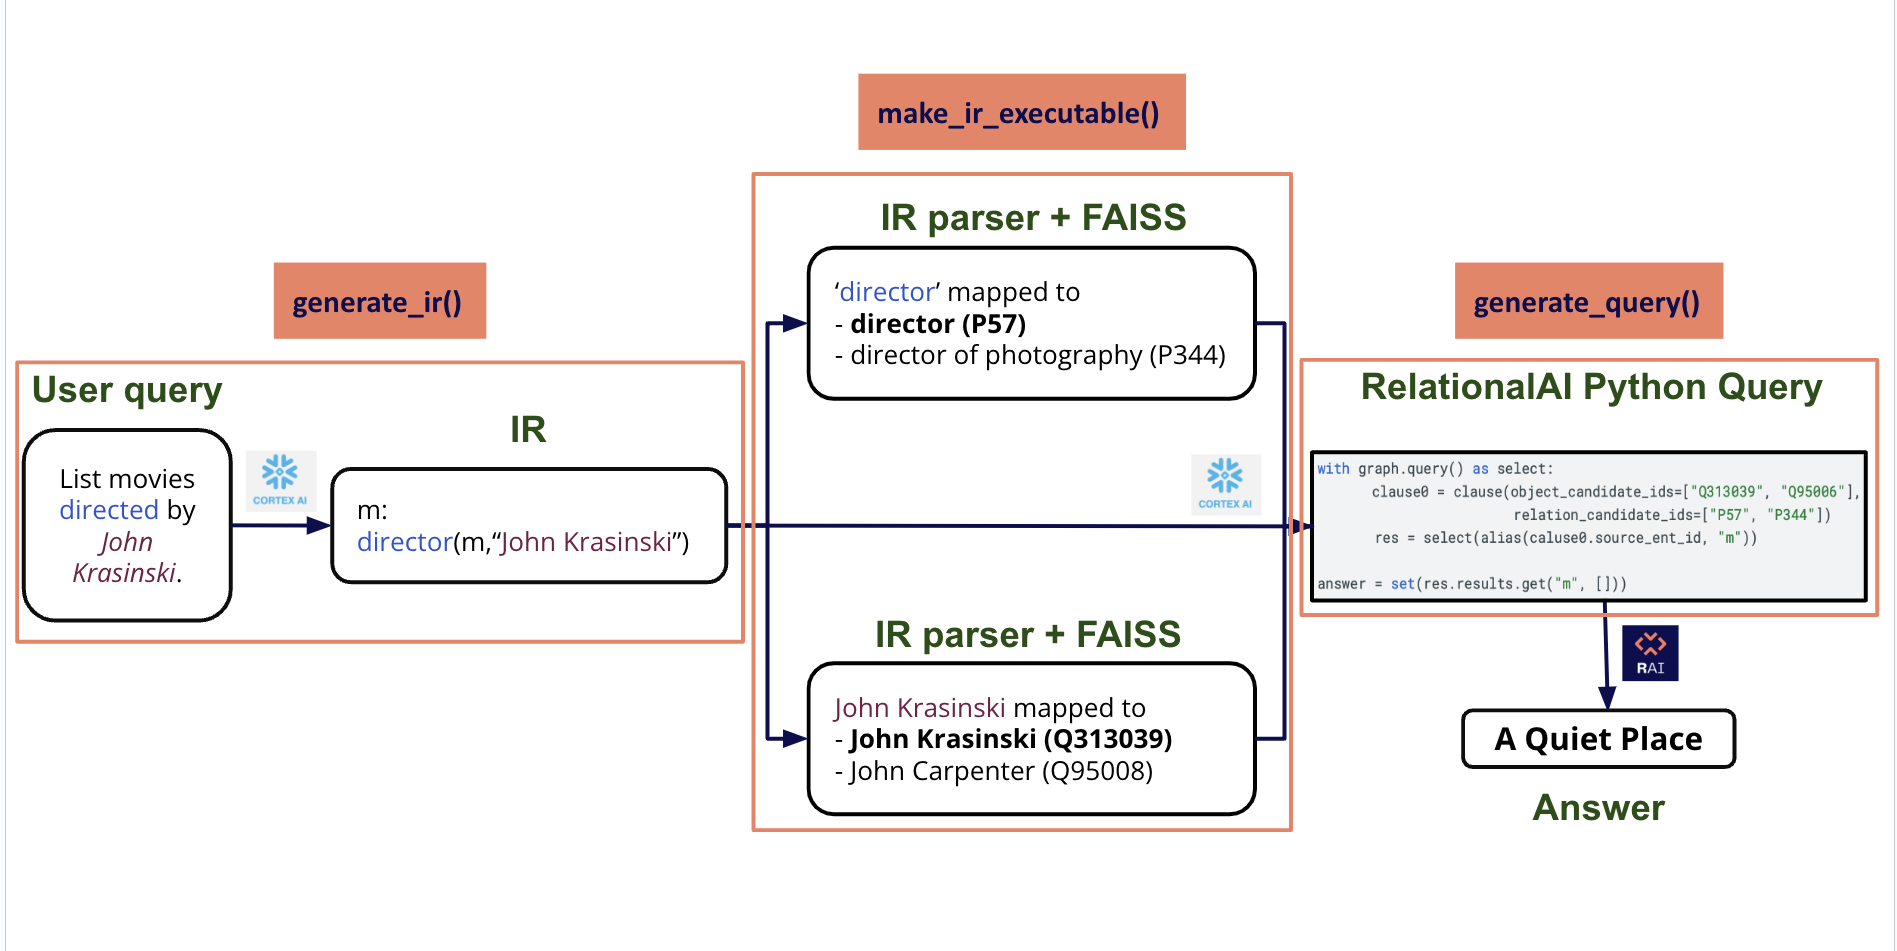

* Let's get ready to use our system! You need to

  - Establish connection with Snowflake to interact with SPCS

  - Select your desired Cortex AI models (for the Complete & Embedding tasks) needed in our system
  
    - Click [here](https://docs.snowflake.com/en/user-guide/snowflake-cortex/llm-functions) to find the list of available models in your region. 

In [8]:
## establish connection with Snowflake to interact with Snowpark Container Service
connection = connector.connect(**connection_params)

## Pick your favorite Cortex AI models for Complete & Embedding tasks
llm_name = "llama3.1-70b"
embedding_model_name = "e5-base-v2"

* Next, we iteratively process each NL question to

  - generate the IR, make it executable and generate the corresponding RelationalAI Python query 



#### Troubleshooting

In case you encounter the following issue, please follow the recommended steps:

- *Server Overload Error*
  
   If the Snowflake server becomes unresponsive and shows a 'Server overloaded' error:
   - To resolve the issue, run ['this'](https://github.com/RelationalAI/llms-mlds/blob/main/kgqa_docker/README.md#step-6--launch-a-snowflake-service---copy-paste-output-to-sf-worksheet-and-run) from Line that says *"DROP SERVICE IF EXISTS <service_name_defined_in_config>;"*

In [9]:
# Initialize the list of IR, FAISS output, and RelationalAI Python queries
irs = []
faiss_output = []
relationalai_queries = []

# process each NL question
for nlq in list_of_questions:

    # Step 1: NL question to IR

    # parse the question for SQL query
    nlq = nlq.replace("'","''")

    # query IR service & get the IR
    query = f"""SELECT generate_ir('{nlq}', '{llm_name}') as result;"""
    ir = connection.cursor().execute(query).fetchone()[0][1:-1]

    irs.append(ir)

    # Step 2: Generating executable IR using similarity search (SS) over the KG

    # query SS service
    query = f"""SELECT make_ir_excecutable('{ir}', '{embedding_model_name}') as result;"""
    df_ss = connection.cursor().execute(query).fetch_pandas_all()["RESULT"][0]

    # Extract SS outputs from df_ss
    matches, scores = reformat_match_output(df_ss)
    matches = str(matches).replace("'",'"')
    faiss_output.append(matches)

    # Step 3: Generating RelationalAI Python query

    # query query generator service
    query = f"""SELECT generate_query('{nlq}','{ir}','{matches}', '{llm_name}') as result;"""
    relationalai_query = connection.cursor().execute(query).fetch_pandas_all()["RESULT"][0]

    # Parse RelationalAI query
    relationalai_query = relationalai_query.replace("\\n","\n").replace("\\","").strip('"')
    relationalai_queries.append(relationalai_query)

* Let's see how the system translates the first NL question into a RelationalAI Python query.

In [10]:
i = 2
print(f"\033[1mNL Query\033[0m \n {list_of_questions[i]}\n")
print(f"\033[1mIR\033[0m \n {irs[i]}\n")
print(f"\033[1mRelationalAI Python query\033[0m \n\n {relationalai_queries[i]}")

NL Query 
 List movies directed by John Kransinski.

IR 
 m: director(m, \"John Krasinski\")

RelationalAI Python query 

 with graph.query() as select:
    clause0 = clause(object_candidate_ids=["Q313039","Q95008"], relation_candidate_ids=["P57","P344"])
    res_relations = select(alias(clause0.source_ent_id, "m"))
results = set(res_relations.results.get("m", []))
print(results)


* Now, let's run the generated queries to see the results.

  - Note that, running the queries retrieves the IDs of the response.

In [11]:
# Define the context dictionary to be used in query execution
clause = TripletClause(Triplet)
context = {"graph": kg_model, "clause": clause, "alias": alias}

# Initialize the list of QIDs of the response 
responses_entity_id_format = []

# Iterate over relationalai queries
for q in relationalai_queries:
    # Execute relationalai query to get QID of the response
    response = execute_query(q, context)
    responses_entity_id_format.append(response)

* With IDs at hand, we can easily retrieve the NL responses by joining IDs with their corresponding labels.

In [12]:
responses_nl_format = []

# Iterate over non-empty responses 
for response in responses_entity_id_format:

    if response != set():

        # Get the label of all IDs in response set
        with kg_model.query() as select:
            lb = Label()
            lb.lid.in_(response)
            label_names = select(lb, alias(lb.lname,"label"))
        responses_nl_format.append(set(label_names.results.get("label", [])))

    else:

        responses_nl_format.append(set())

* We wrap up by displaying the questions with their corresponding answers.

In [13]:
for idx, res in enumerate(responses_nl_format):
    
    res = ', '.join(res) if res != set() else "NULL"
    print(f"Question: {list_of_questions[idx]}")
    print(f"Answer: {res}")
    print("\n==========\n")

Question: Name the actors of The Silent One.
Answer: Alan Adair, Lea Massari, Suzanne Flon, Linda Gray


Question: Who is the director of The Quiet Place?
Answer: John Krasinski


Question: List movies directed by John Kransinski.
Answer: A Quiet Place


Question: Which movie's director is married to a cast member?
Answer: A Quiet Place


Question: Which movie's director was born in the same city as one of the cast members?
Answer: Dunkirk


Question: Name a movie whose producer is the sibling of one of the cast members.
Answer: The Royal Tenenbaums


Question: In which movie is one of the cast members the child of the director?
Answer: A Separation


Question: Name films directed by either Christopher Nolan or Steven Spielberg.
Answer: Dunkirk, Inception, The Dark Knight, The Prestige, Schindler's List, War Horse, Saving Private Ryan


Question: Name movies either directed or produced by Steven Spielberg.
Answer: Jurassic World: Fallen Kingdom, Schindler's List, War Horse, Men in Blac

We’ve verified all the answers to the questions, and they’re accurate according to the current Wikidata snapshot!

Brought to you by [RelationalAI](https://relational.ai) & Snowflake Native Applications!